# Real Time Gait Asymmetry Detection  

In this notebook we are going to achieve the following:

1. **Create the Training Dataset**: We will preprocess and combine data from different sources to create a comprehensive training dataset for real time gait asymmetry detection.
2. **Feature Selection and Dimensionality Reduction**: We will identify the most relevant features for real time gait asymmetry detection using dimensionality reduction techniques.
3. **Model Evaluation**: We will test and compare the performance of multiple machine learning and deep learning algorithms for real time gait asymmetry detection.

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import Input
import joblib
from feature_extraction import generate_rolling_windows
from data_preprocessing import clean_extra_files, detection_merge_subject_features, detection_merge_raw_npz_files, detection_merge_csv_datasets, detection_merge_npz_datasets


# Constants
base_dir    = 'Data'
healthy_dir = 'Data/Healthy'
stroke_dir  = 'Data/Stroke'

detection_time_domain_name = 'detection_time_domain.csv'
detection_asymmetry_name   = 'detection_asymmetry.csv'

## Data Preprocessing, Feature Selection and Dimensionality Reduction

The first step is to create the dataset for the gait asymmetry and extract meaningful features from raw data. The goal is to create a set of different datasets that will provide a holistic view and different insights that we can use with the aim of creating a model that will provide a real time gait asymmetry detection. The process here includes the following steps:
1. Create a new base dataset that includes data in 2 second windows and a 1 second stride.
2. Extract simple statistic features from the 2 second signal like max, min and std. The simple statistics proved to be meaningful information for the classification task.
3. Extract a set of simple symmetry and asymmetry features from swing and stride times.

The data provided were designed for classification, since we have only a label for the whole signal as either 'Stroke Patient' or 'Healthy Subject'. In order to create the new real time asymmetry detection model we need to ensure that we have the correct labels. According to [Physio-pedia](https://www.physio-pedia.com/The_Gait_Cycle) the average gait cycle of a healthy adult is [1.2, 1.8] seconds. Taking into consideration the fact that impaired patients tend to have a longer stride we choose to use a 2 second window with a 1 second stride.

In [2]:
# Create the new datasets for the healthy subjects

# 1. Create all the feature files for the statistical, asymmetry and raw data 
for patient_id in os.listdir(healthy_dir):
    patient_path = os.path.join(healthy_dir, patient_id)
    
    if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
        continue
    #
    try:
        generate_rolling_windows(patient_path)
    except Exception as e:
        print(f'Error processing {patient_id}: {e}')
        
# 2. Merge all type of datasets into a single file for better training
detection_merge_subject_features(healthy_dir, detection_time_domain_name, detection_time_domain_name)
detection_merge_subject_features(healthy_dir, detection_asymmetry_name, detection_asymmetry_name)
detection_merge_raw_npz_files(healthy_dir)

Generated and saved all 3 datasets to: Data/Healthy/Patient_8
Generated and saved all 3 datasets to: Data/Healthy/Patient_1
Generated and saved all 3 datasets to: Data/Healthy/Patient_6
Generated and saved all 3 datasets to: Data/Healthy/Patient_7
Generated and saved all 3 datasets to: Data/Healthy/Patient_9
Generated and saved all 3 datasets to: Data/Healthy/Patient_5
Generated and saved all 3 datasets to: Data/Healthy/Patient_2
Generated and saved all 3 datasets to: Data/Healthy/Patient_3
Generated and saved all 3 datasets to: Data/Healthy/Patient_4
Merged 9 files into detection_time_domain.csv
Merged 9 files into detection_asymmetry.csv
Merged 9 files into all_subject_raw_windows.npz


In [3]:
# Create the new datasets for the stroke patients

# 1. Create all the feature files for the statistical, asymmetry and raw data 
for patient_id in os.listdir(stroke_dir):
    patient_path = os.path.join(stroke_dir, patient_id)
    
    if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
        continue
    
    try:
        generate_rolling_windows(patient_path)
    except Exception as e:
        print(f'Error processing {patient_id}: {e}')
        
# 2. Merge all type of datasets into a single file for better training
detection_merge_subject_features(stroke_dir, detection_time_domain_name, detection_time_domain_name)
detection_merge_subject_features(stroke_dir, detection_asymmetry_name, detection_asymmetry_name)
detection_merge_raw_npz_files(stroke_dir)

Generated and saved all 3 datasets to: Data/Stroke/Patient_8
Generated and saved all 3 datasets to: Data/Stroke/Patient_1
Generated and saved all 3 datasets to: Data/Stroke/Patient_6
Generated and saved all 3 datasets to: Data/Stroke/Patient_7
Generated and saved all 3 datasets to: Data/Stroke/Patient_9
Generated and saved all 3 datasets to: Data/Stroke/Patient_5
Generated and saved all 3 datasets to: Data/Stroke/Patient_2
Generated and saved all 3 datasets to: Data/Stroke/Patient_3
Generated and saved all 3 datasets to: Data/Stroke/Patient_4
Merged 9 files into detection_time_domain.csv
Merged 9 files into detection_asymmetry.csv
Merged 9 files into all_subject_raw_windows.npz


In [4]:
# Merge the healthy subjects and stroke patients to a single file
detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_time_domain_name)
detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_asymmetry_name)
detection_merge_npz_datasets(base_dir)

Saved dataset detection_time_domain.csv with shape (4826, 16) to detection_time_domain.csv
Saved dataset detection_asymmetry.csv with shape (4826, 10) to detection_asymmetry.csv
Merged 2 files into all_subject_raw_windows.npz


## Gait Asymmetry Detection — Time-Domain Feature Model

This part of the notebook trains a binary classifier to detect gait asymmetry using time-domain features extracted from rolling IMU windows.

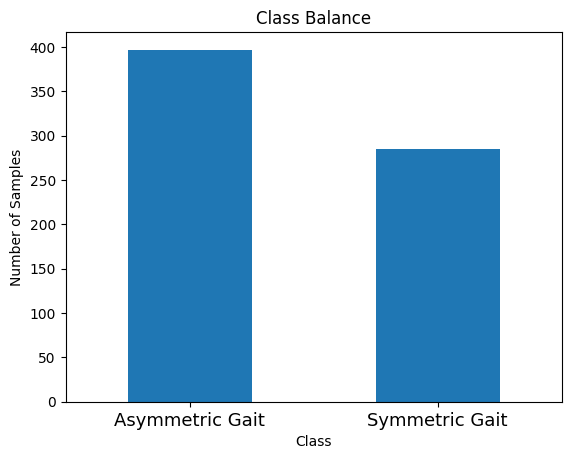

In [ ]:
# Load Dataset
time_domain_data = pd.read_csv('Data/final/detection_time_domain.csv')

# Filter for Gait Windows Only (label 0 or 1)
data_time_domain_gait = time_domain_data[time_domain_data['label_moderate'].isin([0, 1])].copy()
target_variable = 'label_moderate'

# Calculate class frequencies
class_counts = data_time_domain_gait[target_variable].value_counts()
bars = ['Asymmetric Gait', 'Symmetric Gait']
labels_position = np.arange(len(bars))


# Visualize class distribution
class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(labels_position, bars, rotation=360, fontsize='13')
plt.show()


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.522     0.537     0.529       361
           1      0.461     0.445     0.453       321

    accuracy                          0.494       682
   macro avg      0.491     0.491     0.491       682
weighted avg      0.493     0.494     0.494       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.611     0.535     0.570       361
           1      0.541     0.617     0.576       321

    accuracy                          0.573       682
   macro avg      0.576     0.576     0.573       682
weighted avg      0.578     0.573     0.573       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.542     0.521     0.531       361
           1      0.484     0.505     0.494       321

    accuracy                          0.513       682
   macro avg      0.513  

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
Logistic Regression,0.573314,0.576419,0.540984,0.616822
SVM (linear),0.535191,0.518968,0.505917,0.532710
Gradient Boosting,0.513196,0.493902,0.483582,0.504673
XGBoost,0.492669,0.462733,0.461300,0.464174
Random Forest,0.494135,0.453249,0.461290,0.445483
MLP,0.500000,0.447326,0.466216,0.429907


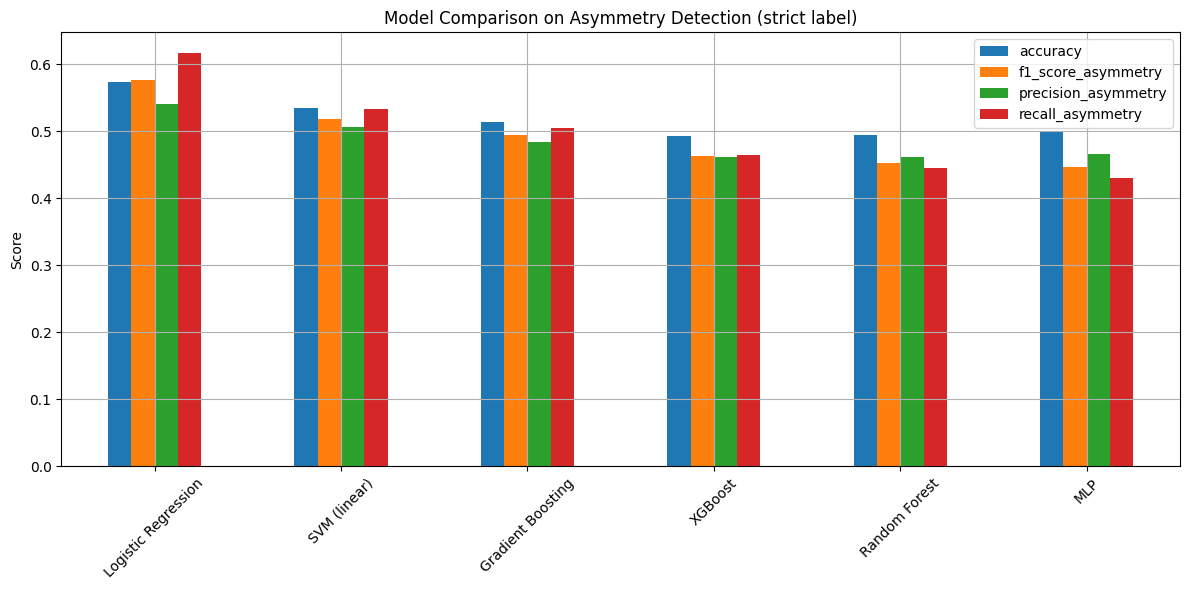

Saved best model: models/detection_strict_logistic_regression.pkl

Training model: Random Forest
              precision    recall  f1-score   support

           0      0.385     0.340     0.361       285
           1      0.563     0.610     0.585       397

    accuracy                          0.497       682
   macro avg      0.474     0.475     0.473       682
weighted avg      0.488     0.497     0.492       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.351     0.119     0.178       285
           1      0.571     0.841     0.680       397

    accuracy                          0.540       682
   macro avg      0.461     0.480     0.429       682
weighted avg      0.479     0.540     0.470       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.373     0.309     0.338       285
           1      0.558     0.627     0.591       397

    accuracy 

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.570381,0.716908,0.581505,0.934509
Logistic Regression,0.539589,0.680244,0.570940,0.841310
MLP,0.548387,0.677149,0.579892,0.813602
XGBoost,0.535191,0.614824,0.593897,0.637280
Gradient Boosting,0.494135,0.590747,0.558296,0.627204
Random Forest,0.497067,0.585248,0.562791,0.609572


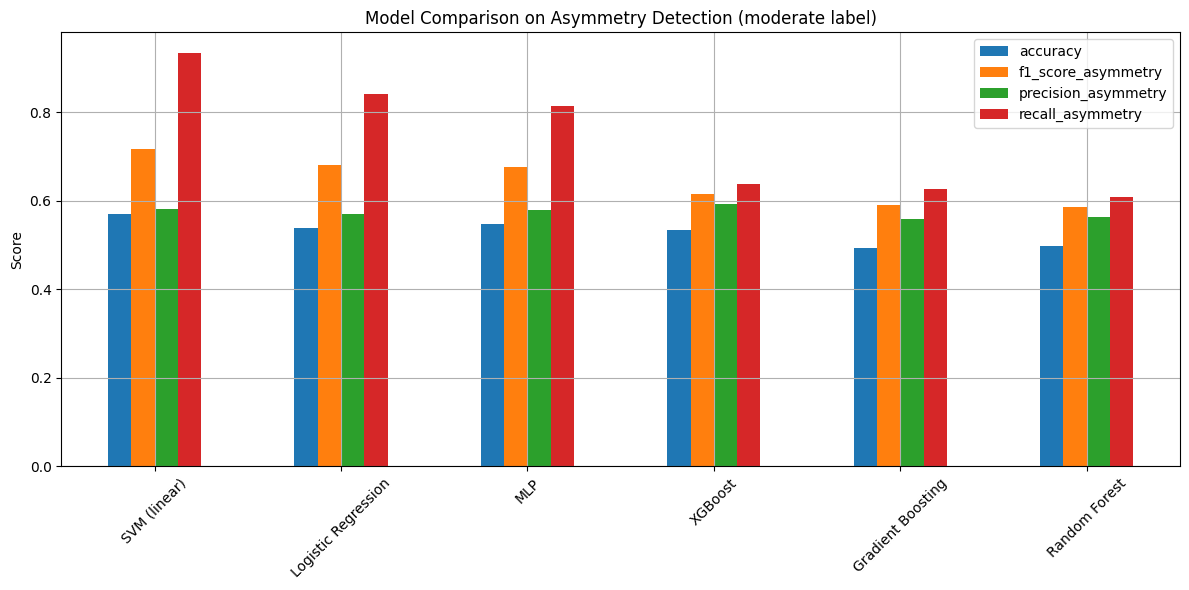

Saved best model: models/detection_moderate_svm_(linear).pkl

Training model: Random Forest
              precision    recall  f1-score   support

           0      0.186     0.056     0.086       197
           1      0.701     0.901     0.789       485

    accuracy                          0.657       682
   macro avg      0.444     0.478     0.437       682
weighted avg      0.553     0.657     0.586       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.152     0.036     0.058       197
           1      0.701     0.920     0.796       485

    accuracy                          0.664       682
   macro avg      0.427     0.478     0.427       682
weighted avg      0.543     0.664     0.583       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.247     0.107     0.149       197
           1      0.705     0.868     0.778       485

    accuracy      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

           0      0.213     0.132     0.163       197
           1      0.695     0.802     0.744       485

    accuracy                          0.609       682
   macro avg      0.454     0.467     0.454       682
weighted avg      0.556     0.609     0.577       682


Model Comparison Summary:


,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.711144,0.831191,0.711144,1.000000
Logistic Regression,0.664223,0.795718,0.701258,0.919588
Random Forest,0.656891,0.788809,0.701445,0.901031
MLP,0.653959,0.786618,0.700483,0.896907
Gradient Boosting,0.648094,0.778189,0.705193,0.868041
XGBoost,0.608504,0.744498,0.694643,0.802062


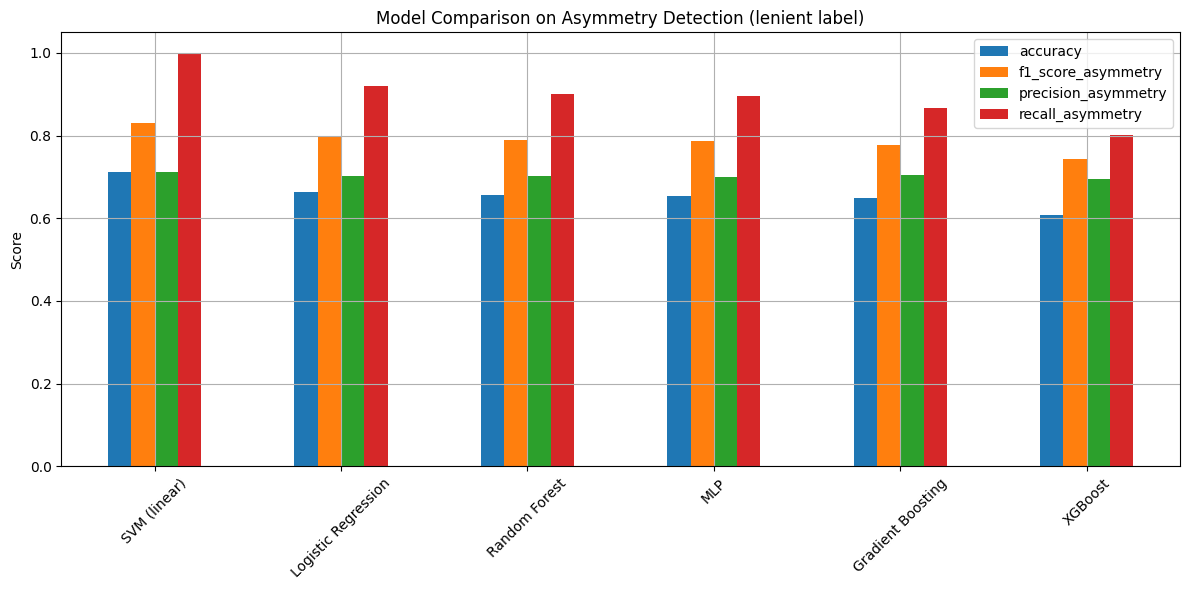

Saved best model: models/detection_lenient_svm_(linear).pkl


In [6]:
# Define Features and Labels
feature_cols = [
    'gyro-right-z-axis-max', 'gyro-left-z-axis-max',
    'gyro-right-z-axis-min', 'gyro-left-z-axis-min',
    'accel-right-z-axis-max', 'accel-left-z-axis-max',
    'accel-right-z-axis-min', 'accel-left-z-axis-min'
]

labels = ['label_strict', 'label_moderate', 'label_lenient']


for label in labels:
    label_type = label.split('_')[1]
    X = data_time_domain_gait[feature_cols].values
    y = data_time_domain_gait[label].values
    groups = data_time_domain_gait['patient_id'].values

    # Normalize Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-Validation Setup
    gkf = GroupKFold(n_splits=5)

    # Define All Models to Compare
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(),
        'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, alpha=1e-4),
        'SVM (linear)': SVC(kernel='linear', probability=True),
        'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

    # Train and Evaluate All Models
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        y_true_all, y_pred_all = [], []

        for train_idx, test_idx in gkf.split(X_scaled, y, groups):
            model.fit(X_scaled[train_idx], y[train_idx])
            y_pred = model.predict(X_scaled[test_idx])
            y_true_all.extend(y[test_idx])
            y_pred_all.extend(y_pred)

        report = classification_report(y_true_all, y_pred_all, output_dict=True)
        results[name] = report
        print(classification_report(y_true_all, y_pred_all, digits=3))

    # Summarize results
    summary = pd.DataFrame({
        model: {
            'accuracy': results[model]['accuracy'],
            'f1_score_asymmetry': results[model]['1']['f1-score'],
            'precision_asymmetry': results[model]['1']['precision'],
            'recall_asymmetry': results[model]['1']['recall']
        }
        for model in results
    }).T.sort_values(by='f1_score_asymmetry', ascending=False)

    # Save metrics to CSV
    summary.to_csv(f"detection_model_comparison_{label_type}.csv")
    print("\nModel Comparison Summary:")
    display(summary)

    # Plot
    summary.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Model Comparison on Asymmetry Detection ({label_type} label)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save best model
    best_model_name = summary.index[0]
    best_model = models[best_model_name]
    best_model.fit(X_scaled, y)

    model_filename = f"models/detection_{label_type}_{best_model_name.replace(' ', '_').lower()}.pkl"
    scaler_filename = f"models/detection_{label_type}_scaler.pkl"
    joblib.dump(best_model, model_filename)
    joblib.dump(scaler, scaler_filename)

    print(f"Saved best model: {model_filename}")

## Results 

| Label Type       | Behavior                                                 |
| ---------------- | -------------------------------------------------------- |
| `label_strict`   | Low recall, very few positive samples, ~60% performance  |
| `label_moderate` | Balanced but noisy performance                           |
| `label_lenient`  | Higher F1 and accuracy (~80%)                           |



### Why label_lenient Performs Better?

1. More positive-asymmetry samples:
    - The model has more training signal instances
    - Reduces the label sparsity between the two classes

2. Less ambiguous class boundaries:
    - Even mild asymmetry windows become 'positives'

3. Possibly better idea in practice since:
    - Mild asymmetries do matter in stroke rehab
    - Detecting early signs may be more useful than catching only extreme events

<br><br/>
With the current solution we likely get:

- **More false positives**
- But also more opportunities for timely correction

A tradeoff we are willing to make in stroke patients rehab to ensure that even in smaller cases of asymmetry we provide opportunities for the user to correct the gait cycle.

---

## 2. Raw Data Classification

### Simple CNN Architecture

In [7]:
def cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model



Fold 1


2025-05-21 13:06:49.021751: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-21 13:06:49.021788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-21 13:06:49.021797: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-21 13:06:49.021822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 13:06:49.021833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-21 13:06:49.582988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Fold 3
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3815eb880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Fold 5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


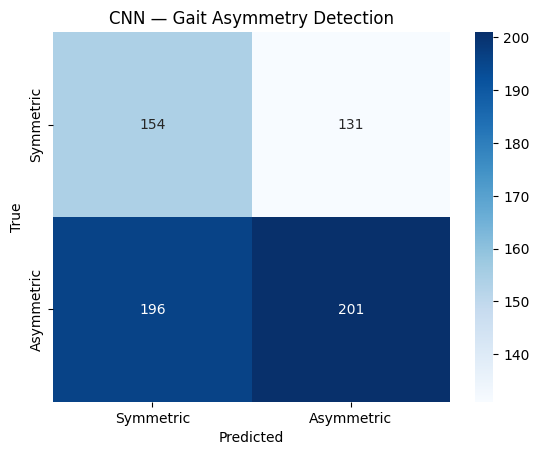

In [9]:
# CNN Model — Gait Asymmetry Detection from Raw IMU Windows

# Load the .npz dataset
data = np.load('all_subject_raw_windows.npz')
X = data['X']
y = data['label_moderate']
groups = data['patient_id']

# Filter out undefined gait cycle with label = 2
valid_idx = y != 2
X = X[valid_idx]
y = y[valid_idx]
groups = groups[valid_idx]

# Normalize per-feature
X = X.astype(np.float32)
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-7)

# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f'\nFold {fold + 1}')

    model = cnn_model(input_shape=X.shape[1:])
    history = model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X[test_idx]).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(y_pred)

# Final Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Symmetric', 'Asymmetric'], yticklabels=['Symmetric', 'Asymmetric'])
plt.title('CNN — Gait Asymmetry Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Shallow MLP Architecture

In [10]:
def shallow_mlp_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model


Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Fold 5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


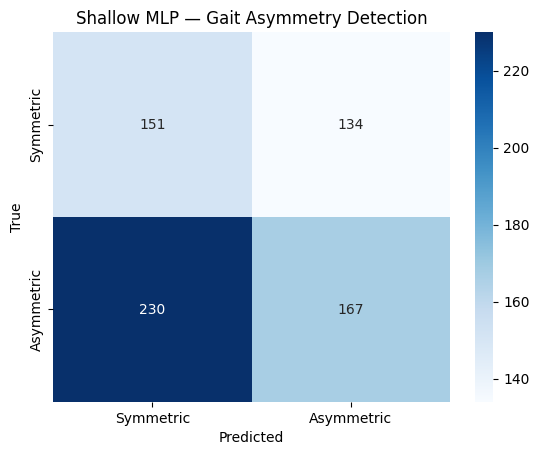

In [ ]:
# Shallow MLP Model — Gait Asymmetry Detection from Raw IMU Windows

# Load the .npz dataset
data = np.load('Data/final/all_subject_raw_windows.npz')
X = data['X']
y = data['label_moderate']
groups = data['patient_id']

# Filter out undefined gait cycle with label = 2
valid_idx = y != 2
X = X[valid_idx]
y = y[valid_idx]
groups = groups[valid_idx]

# Normalize per-feature
X = X.astype(np.float32)
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-7)

# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f'\nFold {fold + 1}')

    model = shallow_mlp_model(input_shape=X.shape[1:])
    history = model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X[test_idx]).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(y_pred)

# Final Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Symmetric', 'Asymmetric'], yticklabels=['Symmetric', 'Asymmetric'])
plt.title('Shallow MLP — Gait Asymmetry Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Observations

Trained both CNN and Shallow MLP:
1. Tried all label granularities: strict, moderate, lenient
2. All models yield ~50% F1 score (≅ random guessing)
3. This persists across architectures and labels

<br></br>

| Observation                     | Comment                                                                                  |
| -----------------------------   | ---------------------------------------------------------------------------------------- |
| Data pipeline seems to be solid | Good design, clean separation and usage of raw window data sets                          |
| Models seem appropriate         | CNN + MLP are lightweight and suitable for time-windowed data for real life applications |
| The results are **expected**    | Models can’t learn much from limited and low-diversity data                              |

<br></br>

### Improvements  
- We need to create a bigger and more diverse dataset, including more users, experiments and data windows.

---

## 3. Stride Asymmetry 


Training model: LogisticRegression
              precision    recall  f1-score   support

           0      0.990     0.990     0.990       197
           1      0.996     0.996     0.996       485

    accuracy                          0.994       682
   macro avg      0.993     0.993     0.993       682
weighted avg      0.994     0.994     0.994       682


Training model: RandomForest
              precision    recall  f1-score   support

           0      1.000     0.995     0.997       197
           1      0.998     1.000     0.999       485

    accuracy                          0.999       682
   macro avg      0.999     0.997     0.998       682
weighted avg      0.999     0.999     0.999       682


Training model: GradientBoosting
              precision    recall  f1-score   support

           0      1.000     0.995     0.997       197
           1      0.998     1.000     0.999       485

    accuracy                          0.999       682
   macro avg      0.999     

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
RandomForest,0.998534,0.998970,0.997942,1.000000
GradientBoosting,0.998534,0.998970,0.997942,1.000000
SVC (RBF Kernel),0.995601,0.996917,0.993852,1.000000
LogisticRegression,0.994135,0.995876,0.995876,0.995876


✅ Saved best model: detection_asymmetry_randomforest.pkl

Evaluating LogisticRegression


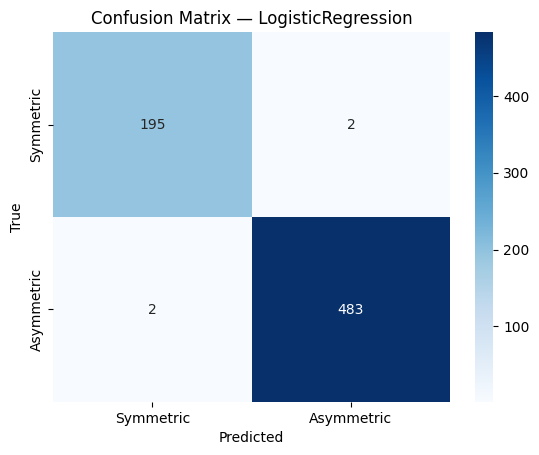


Evaluating RandomForest


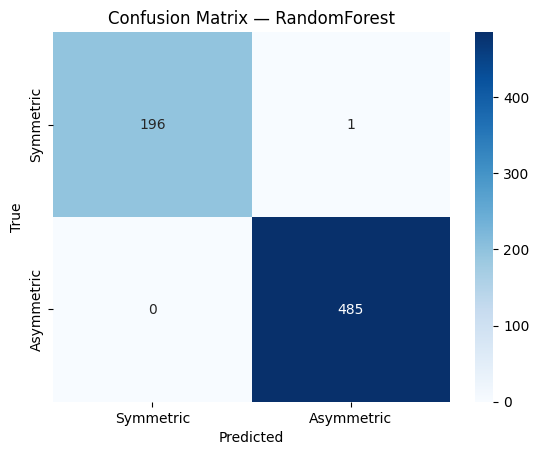


Evaluating GradientBoosting


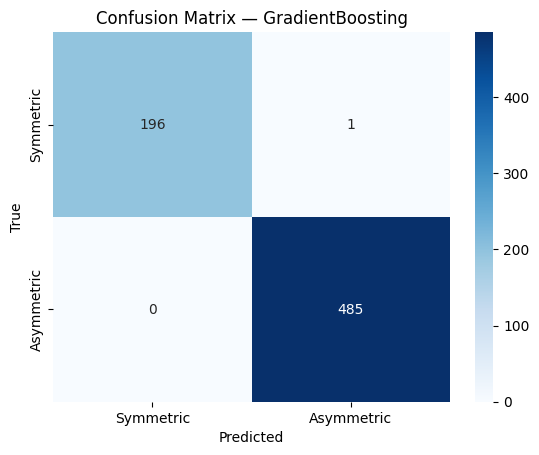


Evaluating SVC (RBF Kernel)


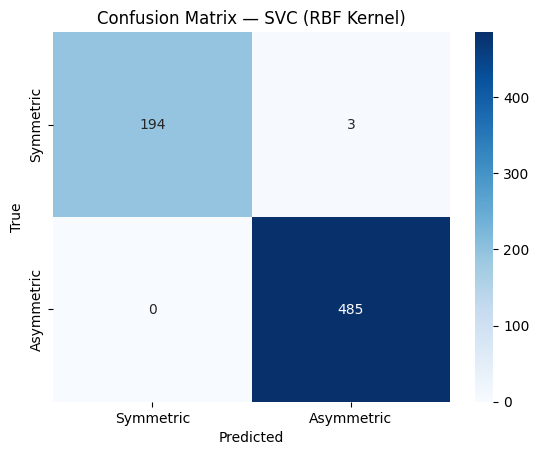

In [ ]:
# Load the asymmetry dataset and filter out undefined label = 2
asymmetry_data = pd.read_csv("Data/final/detection_asymmetry.csv")
asymmetry_data = asymmetry_data[asymmetry_data['label_lenient'] != 2].copy()

# Feature and Label Selection
features = ['gyro-asymmetry-stride-times', 'gyro-symmetry-ratio-stride-times']

X      = asymmetry_data[features].values
X      = asymmetry_data[features].map(lambda x: float(str(x).strip("[]"))).values
y      = asymmetry_data['label_lenient'].values
groups = asymmetry_data['patient_id'].values

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVC (RBF Kernel)": SVC(kernel='rbf', probability=True)
}


# Evaluate Using GroupKFold
gkf = GroupKFold(n_splits=5)
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining model: {name}")
    y_true_all, y_pred_all = [], []

    for train_idx, test_idx in gkf.split(X_scaled, y, groups):
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred = model.predict(X_scaled[test_idx])
        y_true_all.extend(y[test_idx])
        y_pred_all.extend(y_pred)

    report = classification_report(y_true_all, y_pred_all, digits=3, output_dict=True)
    results[name] = report
    print(classification_report(y_true_all, y_pred_all, digits=3))

summary = pd.DataFrame({
    model: {
        'accuracy': results[model]['accuracy'],
        'f1_score_asymmetry': results[model]['1']['f1-score'],
        'precision_asymmetry': results[model]['1']['precision'],
        'recall_asymmetry': results[model]['1']['recall']
    }
    for model in results
}).T.sort_values(by='f1_score_asymmetry', ascending=False)

summary.to_csv("detection_asymmetry_model_comparison.csv")
print("\nModel Comparison Summary:")
display(summary)

# Save Best Model and Scaler
best_model_name = summary.index[0]
best_model      = models[best_model_name]
best_model.fit(X_scaled, y)

joblib.dump(best_model, f"models/detection_asymmetry_{best_model_name.lower().replace(' ', '_')}.pkl")
joblib.dump(scaler, "models/detection_asymmetry_scaler.pkl")
print(f"✅ Saved best model: detection_asymmetry_{best_model_name.lower().replace(' ', '_')}.pkl")


# Plot Confusion Matrices for All Models
for name, model in models.items():
    print(f"\nEvaluating {name}")
    y_true_all, y_pred_all = [], []

    for train_idx, test_idx in gkf.split(X_scaled, y, groups):
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred = model.predict(X_scaled[test_idx])
        y_true_all.extend(y[test_idx])
        y_pred_all.extend(y_pred)

    cm = confusion_matrix(y_true_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Symmetric", "Asymmetric"], yticklabels=["Symmetric", "Asymmetric"])
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

The model based on **gait asymmetry and symmetry metrics** outperforms all other approaches — including deep learning on raw IMU data — due to a combination of domain relevance, simplicity, and effective signal compression.

### Feature Strength

* **Asymmetry index** and **symmetry ratio** directly quantify the physiological imbalance between the left and right stride cycles — the very essence of abnormal gait.
* These metrics are **not abstract**: they represent meaningful biomechanical measurements tied to clinical observations in post-stroke patients.

<br><br/>

### Noise Reduction and Interpretability

* By computing **mean values per window**, we summarize variable-length stride information into stable, scalar features.
* This removes irrelevant variation and allows the model to generalize across subjects while preserving the signal.

<br><br/>

### Model Efficiency

* Classical models (e.g., Logistic Regression, Random Forest) trained on these features are:
  * **Simple and interpretable**
  * **Fast to train and deploy**
  * **Effective even with limited data**


<br><br/>

### Real-Time Deployment Ready
* The model requires only a few scalar inputs per window.
* It is ideal for edge devices due to its low latency, small footprint, and minimal compute requirements.

---

### Clean up all the unnecessary files we created to get the final datasets

In [14]:
clean_extra_files(healthy_dir)
clean_extra_files(stroke_dir)

Deleted detection_time_domain.csv in Data/Healthy/Patient_8
Deleted detection_asymmetry.csv in Data/Healthy/Patient_8
Deleted detection_raw_window.npz in Data/Healthy/Patient_8
Deleted detection_time_domain.csv in Data/Healthy/Patient_1
Deleted detection_asymmetry.csv in Data/Healthy/Patient_1
Deleted detection_raw_window.npz in Data/Healthy/Patient_1
Deleted detection_time_domain.csv in Data/Healthy/Patient_6
Deleted detection_asymmetry.csv in Data/Healthy/Patient_6
Deleted detection_raw_window.npz in Data/Healthy/Patient_6
Deleted detection_time_domain.csv in Data/Healthy/Patient_7
Deleted detection_asymmetry.csv in Data/Healthy/Patient_7
Deleted detection_raw_window.npz in Data/Healthy/Patient_7
Deleted detection_time_domain.csv in Data/Healthy/Patient_9
Deleted detection_asymmetry.csv in Data/Healthy/Patient_9
Deleted detection_raw_window.npz in Data/Healthy/Patient_9
Deleted detection_time_domain.csv in Data/Healthy/Patient_5
Deleted detection_asymmetry.csv in Data/Healthy/Patient